In [1]:
import math
import operator
import numpy as np
import matplotlib.pyplot as plt
from numpy.random import default_rng
from tic_env import TictactoeEnv, OptimalPlayer

# 2. Q-learning

## 2.1 Learning from experts

In [2]:
def grid_to_string(grid):
    char_rep= {0:'-', 1: 'X',-1:'O'}
    return ''.join([char_rep[x] for x in grid.flatten()])

In [3]:
def action_to_key(action,  state):
    if type(action) is tuple:
        action = action[0]*3 + action[1]
    return (action, grid_to_string(state))

In [4]:
def get_state_best_Q(state, Q_vals, player_rnd):
    
    pot_actions = player_rnd.empty(state)
     # optimal choice wrt policy (eps-greedy)
    best_Q = -math.inf
    best_key = None

    for a in pot_actions:                    
        key = action_to_key(a, state)

        Q_a = Q_vals.get(key, 0)

        if (Q_a > best_Q):
            best_Q = Q_a
            best_key = key
    return best_key, best_Q

In [5]:
### Q-learning algorithm

# game constants
Turns = np.array(['X','O'])
max_game_length = 9
seed = 42
rng = default_rng(seed)
env = TictactoeEnv()
Q_vals = {}

# training constants
epoch = 20000
lr = 0.05
df = 0.99
epsilon_greed = 0.4 #set in [0 ; 1[

# plot variables
avg_reward = []
avg_step = 50 
acc_reward = 0

for ep in range(0, epoch):
    # add mean reward to plot every avg_step epoch
    if ((ep+1)%avg_step==0):
        avg_reward.append(acc_reward/avg_step)
        acc_reward = 0
    
    # init Optimal player (epsilon 0.5) and random player, swap starting role every epoch
    player_opt = OptimalPlayer(epsilon=0.5, player=Turns[ep%2])
    player_rnd = OptimalPlayer(epsilon=1., player=Turns[(ep+1)%2])
    
    pred_key, pred_rew  = None, None
    
    # game plays up to 9 times
    for j in range(max_game_length):
        
        # the optimal player plays if it its turn
        if env.current_player == player_opt.player:
            move = player_opt.act(env.grid)
        
        # the learner plays if it is their turn
        else:
            # update Q-val if this is not the first time playing
            if(j != 0 and j!=1):
                Q_v = Q_vals.get(pred_key, 0.0)
                Q_vals[pred_key] = Q_v + lr * (pred_rew + df * get_state_best_Q(env.grid, Q_vals, player_rnd)[1] - Q_v) 
            
            # epsilon chance the player plays randomly
            if(rng.uniform() <= epsilon_greed):
                move = player_rnd.act(env.grid)
            
            # otherwise plays according to the policy
            else:
                key, _ = get_state_best_Q(env.grid, Q_vals, player_rnd)
                move = key[0]
        
        # save current state values before next move is applied
        prev_grid = env.grid.copy()
        round_player = env.current_player
        grid, end, winner = env.step(move, print_grid=False)
        
        # if this is learner's turn, saves additional previous state info 
        if round_player == player_rnd.player:
            pred_key = action_to_key(move, prev_grid)
            pred_rew = env.reward(player_rnd.player)        
        
        # if the game ends, must update the Q-vals before starting a new game
        if end:
            if(round_player != player_rnd.player):
                Q_v = Q_vals.get(pred_key, 0.0)
                # Q_vals[pred_key] = Q_v + lr * (pred_rew - Q_v)   ==> pas checké que mon fix faisait du sens logiquement mais en gros dans la situation actuelle on prenait jamais en compte les moments ou le player perd
                Q_vals[pred_key] = Q_v + lr * (env.reward(player_rnd.player) - Q_v)
            else:
                key = action_to_key(move, prev_grid)
                Q_v = Q_vals.get(key, 0.0)
                Q_vals[key] = Q_v + lr * (env.reward(player_rnd.player) - Q_v)
            
            # reset new game
            acc_reward += env.reward(player_rnd.player)
            env.reset()
            break

In [6]:
Q_vals

{(0, '--X------'): 0.1916765255528446,
 (1, 'O-X-X----'): -0.7302988141344386,
 (5, 'OOXXX----'): -0.0975,
 (0, '---------'): 0.5582487553371561,
 (5, 'X--O-----'): 0.014422648502470983,
 (1, 'X--O-X--O'): 0.051870934318588816,
 (4, 'XXOO-X--O'): 0.06396694873902561,
 (6, 'XXOOXX-OO'): 0.0,
 (7, 'OOX-XX---'): -0.05,
 (1, 'X---O----'): 0.5758279286950356,
 (2, 'XX--O-O--'): 0.9997408802884766,
 (5, 'O-X-----X'): -0.15987660106965357,
 (3, 'OXX--O--X'): 0.0,
 (7, 'OXXO-OX-X'): -0.142625,
 (2, 'XO-------'): 0.23029969957530222,
 (3, 'XOX----O-'): -0.4691130608606724,
 (1, 'X--------'): -0.017405989344365377,
 (2, 'XO---X---'): -0.002475,
 (3, 'XOO--X-X-'): 0.0,
 (4, 'XOOO-X-XX'): -0.0975,
 (7, 'XOX-O----'): 0.14269959017207937,
 (8, 'XOX-O-OX-'): 0.17080828720357968,
 (3, 'XOX-OOOXX'): 0.0,
 (0, '------X--'): 0.19735411728467278,
 (1, 'O---X-X--'): -0.32372040377826433,
 (5, '---------'): 0.09851748718645167,
 (0, '-----X--O'): 0.014350202295300832,
 (1, 'X----XO-O'): -0.05,
 (3, '------X

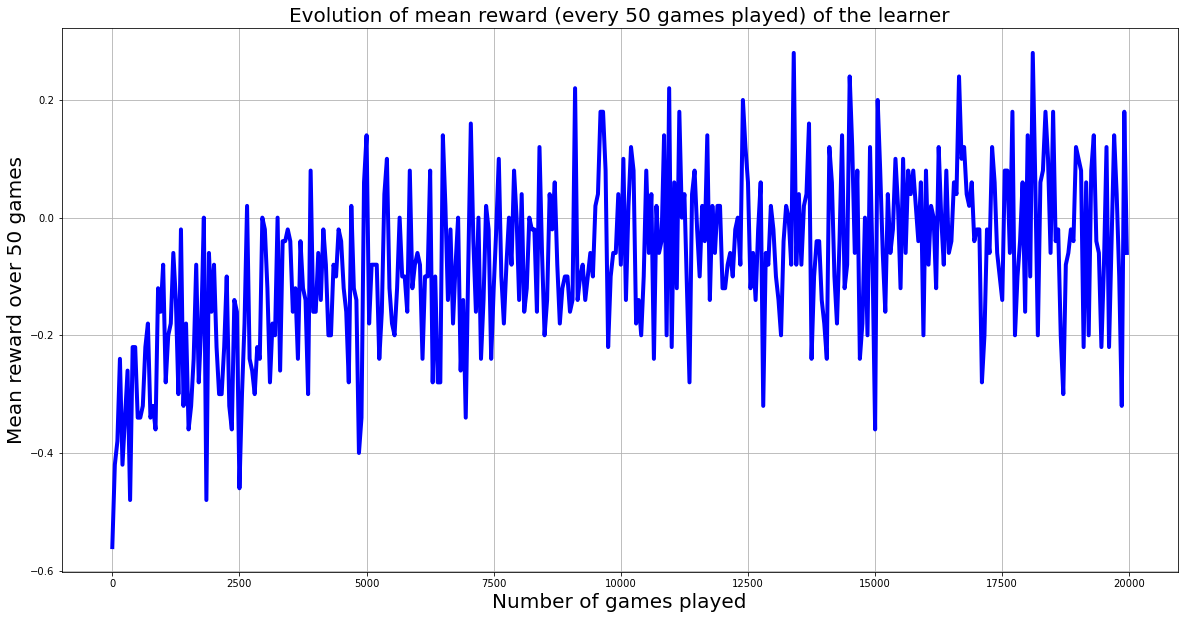

In [7]:
#View evolving mean reward of the learner
plt.figure(figsize=(20, 10))
plt.plot(range(0, 20000, 50), avg_reward, 'b', lw=4)
plt.xlabel('Number of games played', fontsize= 20)
plt.ylabel('Mean reward over {} games'.format(avg_step), fontsize = 20)
plt.title('Evolution of mean reward (every {} games played) of the learner'.format(avg_step), fontsize = 20)
plt.grid()
plt.show()

In [8]:
np.mean(np.array(avg_reward))

-0.07875000000000001

In [9]:
neg_Q = filter(lambda x : x<0 , Q_vals.values())
nb_neg = len([x for x in neg_Q])

print(nb_neg)

3479


In [10]:
print(len(Q_vals.values()) - nb_neg)

3988
